<a href="https://colab.research.google.com/github/haydenlee914/Fraud-Detection-Competition/blob/main/Catboost_0127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Libraries and data

In [ ]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

#test = pd.read_csv("/content/test_dataset (1).csv")
#train = pd.read_csv("/content/training_dataset.csv")

Saving test_dataset.csv to test_dataset.csv


In [ ]:
import io
test = pd.read_csv(io.BytesIO(uploaded['test_dataset.csv']))

In [ ]:
uploaded = files.upload()

Saving training_dataset.csv to training_dataset.csv


In [ ]:
train = pd.read_csv(io.BytesIO(uploaded['training_dataset.csv']))

## Check the shape and NA values

In [ ]:
print(test.shape)
print(train.shape)

(12002, 24)
(17998, 25)


In [ ]:
#check missing values
test.isnull().sum()

claim_number                0
age_of_driver               0
gender                      0
marital_status              2
safty_rating                0
annual_income               0
high_education_ind          0
address_change_ind          0
living_status               0
zip_code                    0
claim_date                  0
claim_day_of_week           0
accident_site               0
past_num_of_claims          0
witness_present_ind        88
liab_prct                   0
channel                     0
policy_report_filed_ind     0
claim_est_payout           14
age_of_vehicle              3
vehicle_category            0
vehicle_price               0
vehicle_color               0
vehicle_weight              0
dtype: int64

In [ ]:
train.isnull().sum()

claim_number                 0
age_of_driver                0
gender                       0
marital_status               5
safty_rating                 0
annual_income                0
high_education_ind           0
address_change_ind           0
living_status                0
zip_code                     0
claim_date                   0
claim_day_of_week            0
accident_site                0
past_num_of_claims           0
witness_present_ind        132
liab_prct                    0
channel                      0
policy_report_filed_ind      0
claim_est_payout            17
age_of_vehicle               8
vehicle_category             0
vehicle_price                0
vehicle_color                0
vehicle_weight               0
fraud                        0
dtype: int64

# Cleaning Data

## Clean NA values

In [ ]:
#there are 88 missing values for witness_present_ind in test data, 0.73% of all observations
#there are 132 missing values for witness_present_ind in train data, 0.73% of all observations
#don't want to exclude the observations, instead replace NA with 0, assuming no witness
test['witness_present_ind'].fillna(0, inplace = True)
train['witness_present_ind'].fillna(0, inplace = True)

In [ ]:
# substitute missing values in marital_status to 0 (not married)
test['marital_status'].fillna(0, inplace = True)
train['marital_status'].fillna(0, inplace = True)

In [ ]:
#claim_est_payout test missing: 14
#age_of_vehicle test missing:  3
#claim_est_payout train missing: 17
#age_of_vehicle train missing: 8
#we are cautious in loosing valuable data, in this case, we use different interpolation techniques
#to estimate the missing values from the other training samples in our dataset.
#we replace the missing value by the mean value of the entire feature column for claim_est_payout and age_of_vehicle

test['claim_est_payout'].fillna((train['claim_est_payout'].mean()), inplace=True)
train['claim_est_payout'].fillna((train['claim_est_payout'].mean()), inplace=True)
test['age_of_vehicle'].fillna((train['age_of_vehicle'].mean()), inplace=True)
train['age_of_vehicle'].fillna((train['age_of_vehicle'].mean()), inplace=True)

In [ ]:
train.dtypes

claim_number                 int64
age_of_driver                int64
gender                      object
marital_status             float64
safty_rating                 int64
annual_income                int64
high_education_ind           int64
address_change_ind           int64
living_status               object
zip_code                     int64
claim_date                  object
claim_day_of_week           object
accident_site               object
past_num_of_claims           int64
witness_present_ind        float64
liab_prct                    int64
channel                     object
policy_report_filed_ind      int64
claim_est_payout           float64
age_of_vehicle             float64
vehicle_category            object
vehicle_price              float64
vehicle_color               object
vehicle_weight             float64
fraud                        int64
dtype: object

In [ ]:
train.describe()

,claim_number,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight,fraud
count,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000,17998.000000
mean,14970.601622,43.695466,0.712524,73.562951,37367.655684,0.699189,0.577286,49875.595955,0.505001,0.230970,49.423269,0.600678,4975.792083,5.008060,23089.123114,23031.322385,0.156295
std,8659.940765,11.959819,0.452598,15.346807,2957.297249,0.458623,0.494004,29214.655149,0.955504,0.421465,33.678470,0.489773,2214.659783,2.257889,11988.429767,12052.385584,0.363604
min,1.000000,18.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.639432,0.000000,2457.329316,2429.429302,-1.000000
25%,7479.250000,35.000000,0.000000,65.000000,35554.000000,0.000000,0.000000,20111.000000,0.000000,0.000000,17.000000,0.000000,3339.205052,3.000000,14279.574850,14164.122133,0.000000
50%,14965.500000,43.000000,1.000000,76.000000,37610.000000,1.000000,1.000000,50028.000000,0.000000,0.000000,50.000000,1.000000,4671.827763,5.000000,20948.879250,20838.150260,0.000000
75%,22467.750000,51.000000,1.000000,85.000000,39318.000000,1.000000,1.000000,80038.000000,1.000000,0.000000,81.000000,1.000000,6254.708103,6.000000,29562.232780,29430.446292,0.000000
max,30000.000000,229.000000,1.000000,100.000000,54333.000000,1.000000,1.000000,85083.000000,6.000000,1.000000,100.000000,1.000000,17218.345010,16.000000,127063.506000,123016.650400,1.000000


## Clean impossible values

In [ ]:
# substitute wrong values in age to mean
age_mean = train['age_of_driver'].mean()
train.loc[train['age_of_driver']>100, 'age_of_driver'] = age_mean
test.loc[test['age_of_driver']>100, 'age_of_driver'] = age_mean

In [ ]:
# substitute wrong values in annual income to mean
income_mean = train['annual_income'].mean()
train.loc[train['annual_income']<0, 'annual_income'] = income_mean
test.loc[test['annual_income']<0, 'annual_income'] = income_mean

In [ ]:
# drop observations that has -1 in fraud column
train = train[train.fraud>=0]

In [ ]:
train.iloc[:,0:25].describe()

,claim_number,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight,fraud
count,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000
mean,14970.468352,43.668396,0.712476,73.562879,37398.932139,0.699250,0.577271,49870.288302,0.504918,0.231009,49.429286,0.600778,4975.640816,5.007895,23090.558736,23031.591635,0.156488
std,8659.446913,11.792997,0.452621,15.347390,2753.454895,0.458597,0.494007,29214.181840,0.955504,0.421490,33.677937,0.489752,2214.771308,2.257869,11988.794310,12052.661459,0.363327
min,1.000000,18.000000,0.000000,1.000000,28896.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.639432,0.000000,2457.329316,2429.429302,0.000000
25%,7479.500000,35.000000,0.000000,65.000000,35555.000000,0.000000,0.000000,20111.000000,0.000000,0.000000,17.000000,0.000000,3338.904738,3.000000,14279.686540,14164.267235,0.000000
50%,14965.000000,43.000000,1.000000,76.000000,37610.000000,1.000000,1.000000,50028.000000,0.000000,0.000000,50.000000,1.000000,4671.535182,5.000000,20955.918110,20837.923870,0.000000
75%,22467.500000,51.000000,1.000000,85.000000,39318.000000,1.000000,1.000000,80038.000000,1.000000,0.000000,81.000000,1.000000,6254.467913,6.000000,29563.713610,29429.861945,0.000000
max,30000.000000,100.000000,1.000000,100.000000,54333.000000,1.000000,1.000000,85083.000000,6.000000,1.000000,100.000000,1.000000,17218.345010,16.000000,127063.506000,123016.650400,1.000000


In [ ]:
test.iloc[:,0:25].describe()

,claim_number,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight
count,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000
mean,15045.335111,43.465795,0.715047,73.702966,37356.413118,0.698134,0.576737,49762.387269,0.494918,0.236961,49.770122,0.601066,5016.454724,4.969340,22925.335594,22860.701764
std,8661.251912,11.765008,0.451411,15.378967,2762.642842,0.459087,0.494097,29133.180765,0.956002,0.425236,33.581191,0.489699,2255.725416,2.226989,12108.888412,12198.142508
min,2.000000,19.000000,0.000000,2.000000,29432.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,471.363743,0.000000,2261.507903,2583.428985
25%,7532.250000,35.000000,0.000000,66.000000,35550.250000,0.000000,0.000000,20111.000000,0.000000,0.000000,18.000000,0.000000,3369.404032,3.000000,14087.559950,13832.434587
50%,15055.500000,43.000000,1.000000,76.000000,37606.000000,1.000000,1.000000,50027.000000,0.000000,0.000000,50.000000,1.000000,4675.285036,5.000000,20642.029325,20508.293695
75%,22559.500000,51.000000,1.000000,85.000000,39313.000000,1.000000,1.000000,80036.750000,1.000000,0.000000,82.000000,1.000000,6293.101028,6.000000,29293.641235,29205.553660
max,29998.000000,100.000000,1.000000,100.000000,56275.000000,1.000000,1.000000,85083.000000,6.000000,1.000000,100.000000,1.000000,23903.366250,14.000000,106991.684500,101818.964200


## Feature Engineering

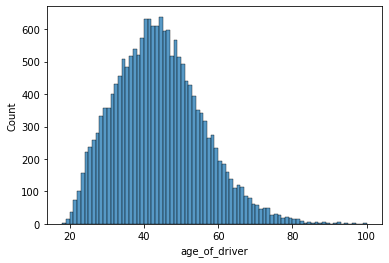

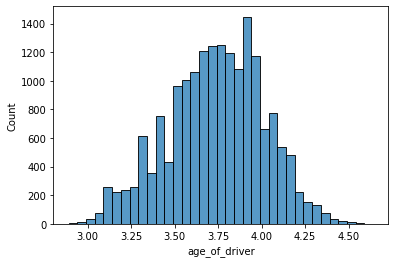

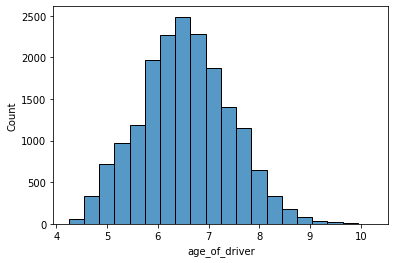

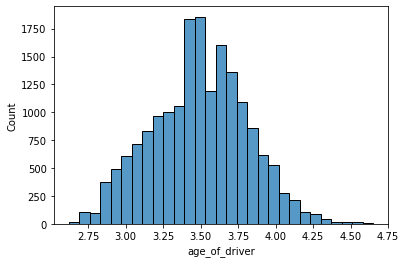

In [ ]:
import matplotlib.pyplot as plt

sns.histplot(train.age_of_driver, binwidth=1)
plt.show()
sns.histplot(np.log(train.age_of_driver), binwidth=0.05)
plt.show()
sns.histplot(np.sqrt(train.age_of_driver), binwidth=0.3)
plt.show()
sns.histplot(np.cbrt(train.age_of_driver), binwidth=0.07)
plt.show()

# use log transformation

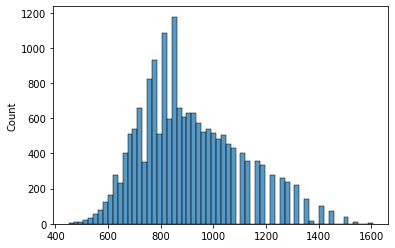

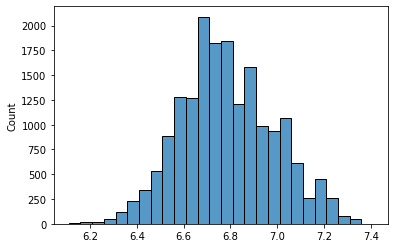

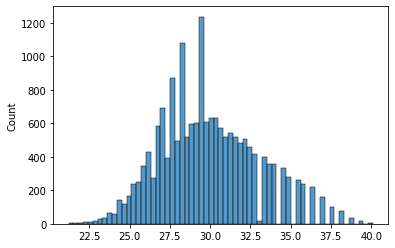

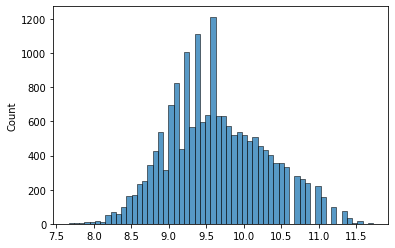

In [ ]:
sns.histplot(train.annual_income/train.age_of_driver)
plt.show()
sns.histplot(np.log(train.annual_income/train.age_of_driver), binwidth=0.05)
plt.show()
sns.histplot(np.sqrt(train.annual_income/train.age_of_driver), binwidth=0.3)
plt.show()
sns.histplot(np.cbrt(train.annual_income/train.age_of_driver), binwidth=0.07)
plt.show()

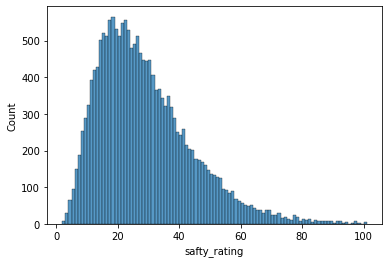

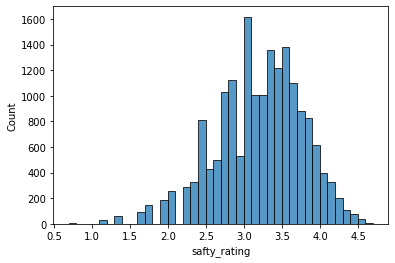

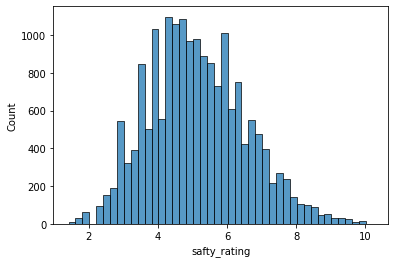

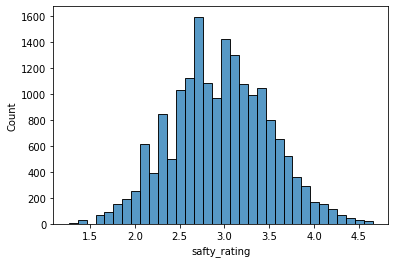

In [ ]:
sns.histplot(-train.safty_rating+102, binwidth=1)
plt.show()
sns.histplot(np.log(-train.safty_rating+102), binwidth=0.1)
plt.show()
sns.histplot(np.sqrt(-train.safty_rating+102), binwidth=0.2)
plt.show()
sns.histplot(np.cbrt(-train.safty_rating+102), binwidth=0.1)
plt.show()

# use cuberoot transformation

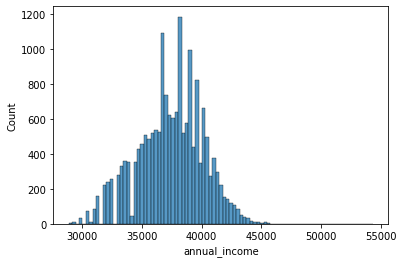

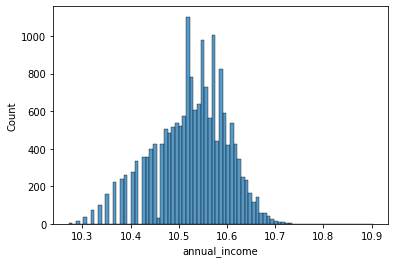

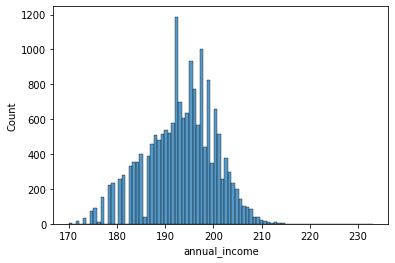

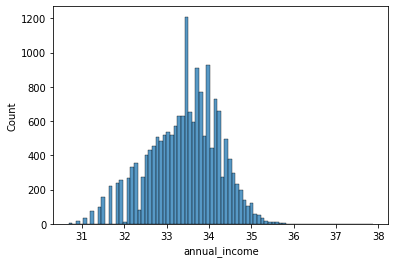

In [ ]:
sns.histplot(train.annual_income)
plt.show()
sns.histplot(np.log(train.annual_income))
plt.show()
sns.histplot(np.sqrt(train.annual_income))
plt.show()
sns.histplot(np.cbrt(train.annual_income))
plt.show()

# log ? unclear

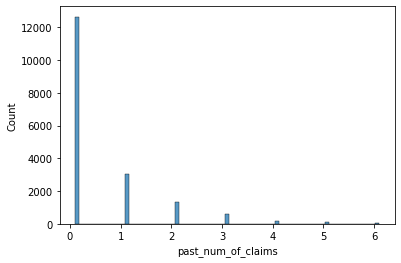

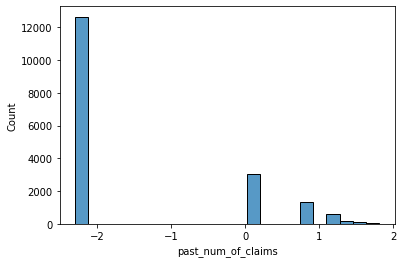

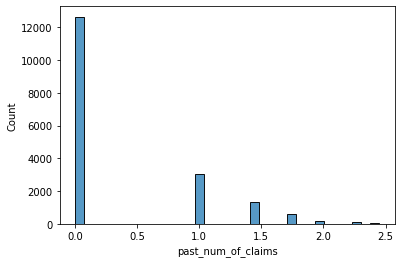

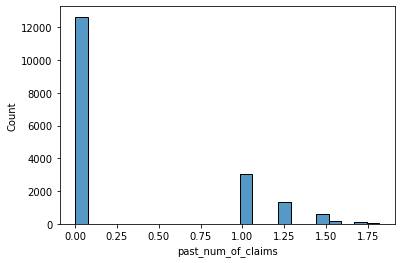

In [ ]:
sns.histplot(train.past_num_of_claims+0.1)
plt.show()
sns.histplot(np.log(train.past_num_of_claims+0.1))
plt.show()
sns.histplot(np.sqrt(train.past_num_of_claims))
plt.show()
sns.histplot(np.cbrt(train.past_num_of_claims))
plt.show()

we can make this into binary variable, whether people had claimed before

In [ ]:
train.head()

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,claim_day_of_week,accident_site,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud,claim_day_of_week_Monday,claim_day_of_week_Saturday,claim_day_of_week_Sunday,claim_day_of_week_Thursday,claim_day_of_week_Tuesday,claim_day_of_week_Wednesday,accident_site_Local,accident_site_Parking Lot,channel_Online,channel_Phone,vehicle_category_Large,vehicle_category_Medium
0,1,46.0,1,1.0,85,38301.0,1,1,1,80006,12/16/2016,Friday,Local,0.0,74,Broker,0,7530.940993,9.0,Compact,12885.45235,white,16161.33381,0,0,0,0,0,0,0,1,0,0,0,0,0
1,3,21.0,0,0.0,75,30445.0,0,1,1,15021,2/12/2015,Thursday,Highway,1.0,79,Online,0,2966.024895,4.0,Large,29429.45218,white,28691.96422,0,0,0,0,1,0,0,0,0,1,0,1,0
2,4,49.0,0,0.0,87,38923.0,0,1,0,20158,12/6/2016,Tuesday,Local,0.0,0,Broker,0,6283.888333,3.0,Compact,21701.18195,white,22090.94758,1,0,0,0,0,1,0,1,0,0,0,0,0
3,5,58.0,0,1.0,58,40605.0,1,0,0,15024,5/5/2016,Thursday,Local,0.0,99,Broker,1,6169.747994,4.0,Medium,13198.27344,other,38329.58106,1,0,0,0,1,0,0,1,0,0,0,0,1
4,6,38.0,1,1.0,95,36380.0,1,0,1,50034,10/27/2015,Tuesday,Highway,1.0,7,Broker,0,4541.387150,7.0,Medium,38060.21122,gray,25876.56319,0,0,0,0,0,1,0,0,0,0,0,0,1


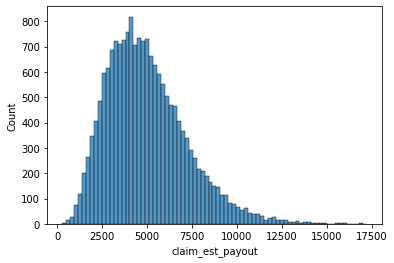

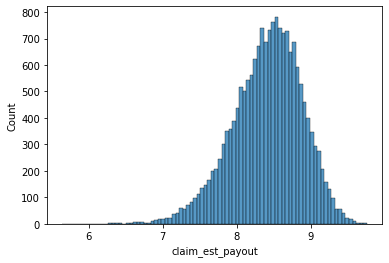

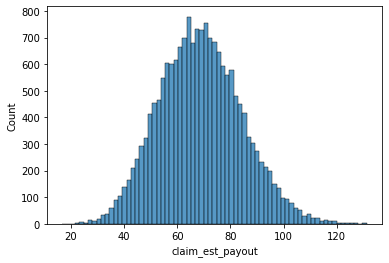

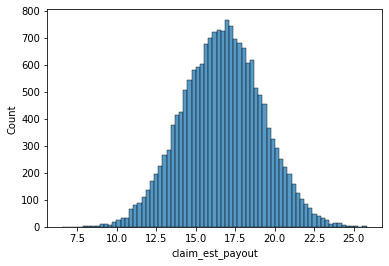

In [ ]:
sns.histplot(train.claim_est_payout)
plt.show()
sns.histplot(np.log(train.claim_est_payout))
plt.show()
sns.histplot(np.sqrt(train.claim_est_payout))
plt.show()
sns.histplot(np.cbrt(train.claim_est_payout))
plt.show()

# use sqrt transformation

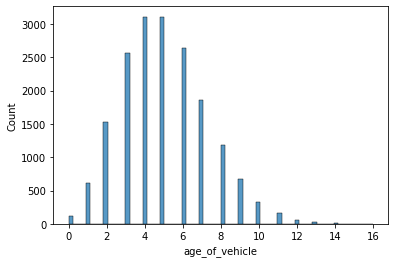

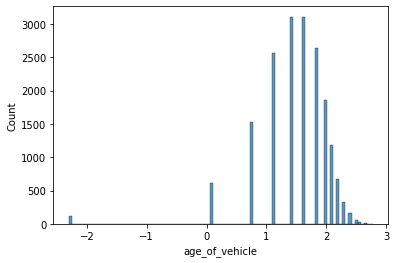

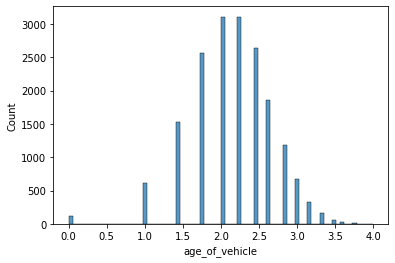

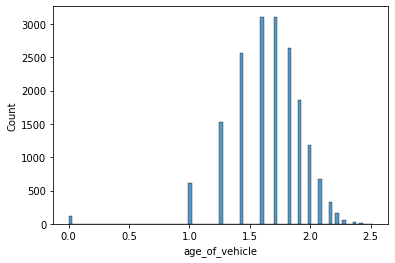

In [ ]:
sns.histplot(train.age_of_vehicle)
plt.show()
sns.histplot(np.log(train.age_of_vehicle+0.1))
plt.show()
sns.histplot(np.sqrt(train.age_of_vehicle))
plt.show()
sns.histplot(np.cbrt(train.age_of_vehicle))
plt.show()

# use sqrt transformation

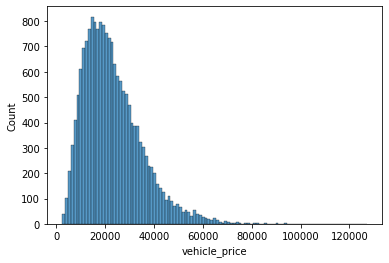

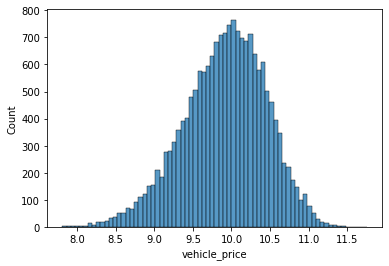

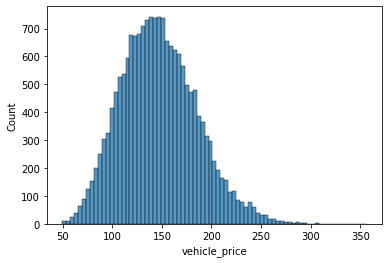

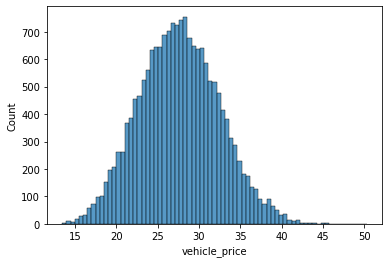

In [ ]:
sns.histplot(train.vehicle_price)
plt.show()
sns.histplot(np.log(train.vehicle_price))
plt.show()
sns.histplot(np.sqrt(train.vehicle_price))
plt.show()
sns.histplot(np.cbrt(train.vehicle_price))
plt.show()

# use log transformation

# Create transformed dataset

In [ ]:
train_t = train.copy()
test_t = test.copy()

In [ ]:
train_t.age_of_driver = np.log(train_t.age_of_driver)
train_t.safty_rating = np.cbrt(-train_t.safty_rating+102)
train_t.annual_income = np.log(train_t.annual_income)
train_t.claim_est_payout = np.sqrt(train_t.claim_est_payout)
train_t.age_of_vehicle = np.sqrt(train_t.age_of_vehicle)
train_t.vehicle_price = np.log(train_t.vehicle_price)

test_t.age_of_driver = np.log(test_t.age_of_driver)
test_t.safty_rating = np.cbrt(-test_t.safty_rating+102)
test_t.annual_income = np.log(test_t.annual_income)
test_t.claim_est_payout = np.sqrt(test_t.claim_est_payout)
test_t.age_of_vehicle = np.sqrt(test_t.age_of_vehicle)
test_t.vehicle_price = np.log(test_t.vehicle_price)

In [ ]:
train_t.describe()

,claim_number,age_of_driver,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,past_num_of_claims,witness_present_ind,liab_prct,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_price,vehicle_weight,fraud
count,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000,17995.000000
mean,14970.468352,3.739715,0.712476,2.954826,10.526640,0.699250,0.577271,49870.288302,0.504918,0.231009,49.429286,0.600778,68.807082,2.172020,9.911787,23031.591635,0.156488
std,8659.446913,0.274678,0.452621,0.544228,0.074637,0.458597,0.494007,29214.181840,0.955504,0.421490,33.677937,0.489752,15.531894,0.538738,0.537168,12052.661459,0.363327
min,1.000000,2.890372,0.000000,1.259921,10.271458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.811884,0.000000,7.806830,2429.429302,0.000000
25%,7479.500000,3.555348,0.000000,2.571282,10.478836,0.000000,0.000000,20111.000000,0.000000,0.000000,17.000000,0.000000,57.783257,1.732051,9.566593,14164.267235,0.000000
50%,14965.000000,3.761200,1.000000,2.962496,10.535025,1.000000,1.000000,50028.000000,0.000000,0.000000,50.000000,1.000000,68.348630,2.236068,9.950176,20837.923870,0.000000
75%,22467.500000,3.931826,1.000000,3.332222,10.579438,1.000000,1.000000,80038.000000,1.000000,0.000000,81.000000,1.000000,79.085194,2.449490,10.294303,29429.861945,0.000000
max,30000.000000,4.605170,1.000000,4.657010,10.902887,1.000000,1.000000,85083.000000,6.000000,1.000000,100.000000,1.000000,131.218692,4.000000,11.752442,123016.650400,1.000000


# Variable Selection

In [ ]:
train_t.columns

Index(['claim_number', 'age_of_driver', 'gender', 'marital_status',
       'safty_rating', 'annual_income', 'high_education_ind',
       'address_change_ind', 'living_status', 'zip_code', 'claim_date',
       'claim_day_of_week', 'accident_site', 'past_num_of_claims',
       'witness_present_ind', 'liab_prct', 'channel',
       'policy_report_filed_ind', 'claim_est_payout', 'age_of_vehicle',
       'vehicle_category', 'vehicle_price', 'vehicle_color', 'vehicle_weight',
       'fraud'],
      dtype='object')

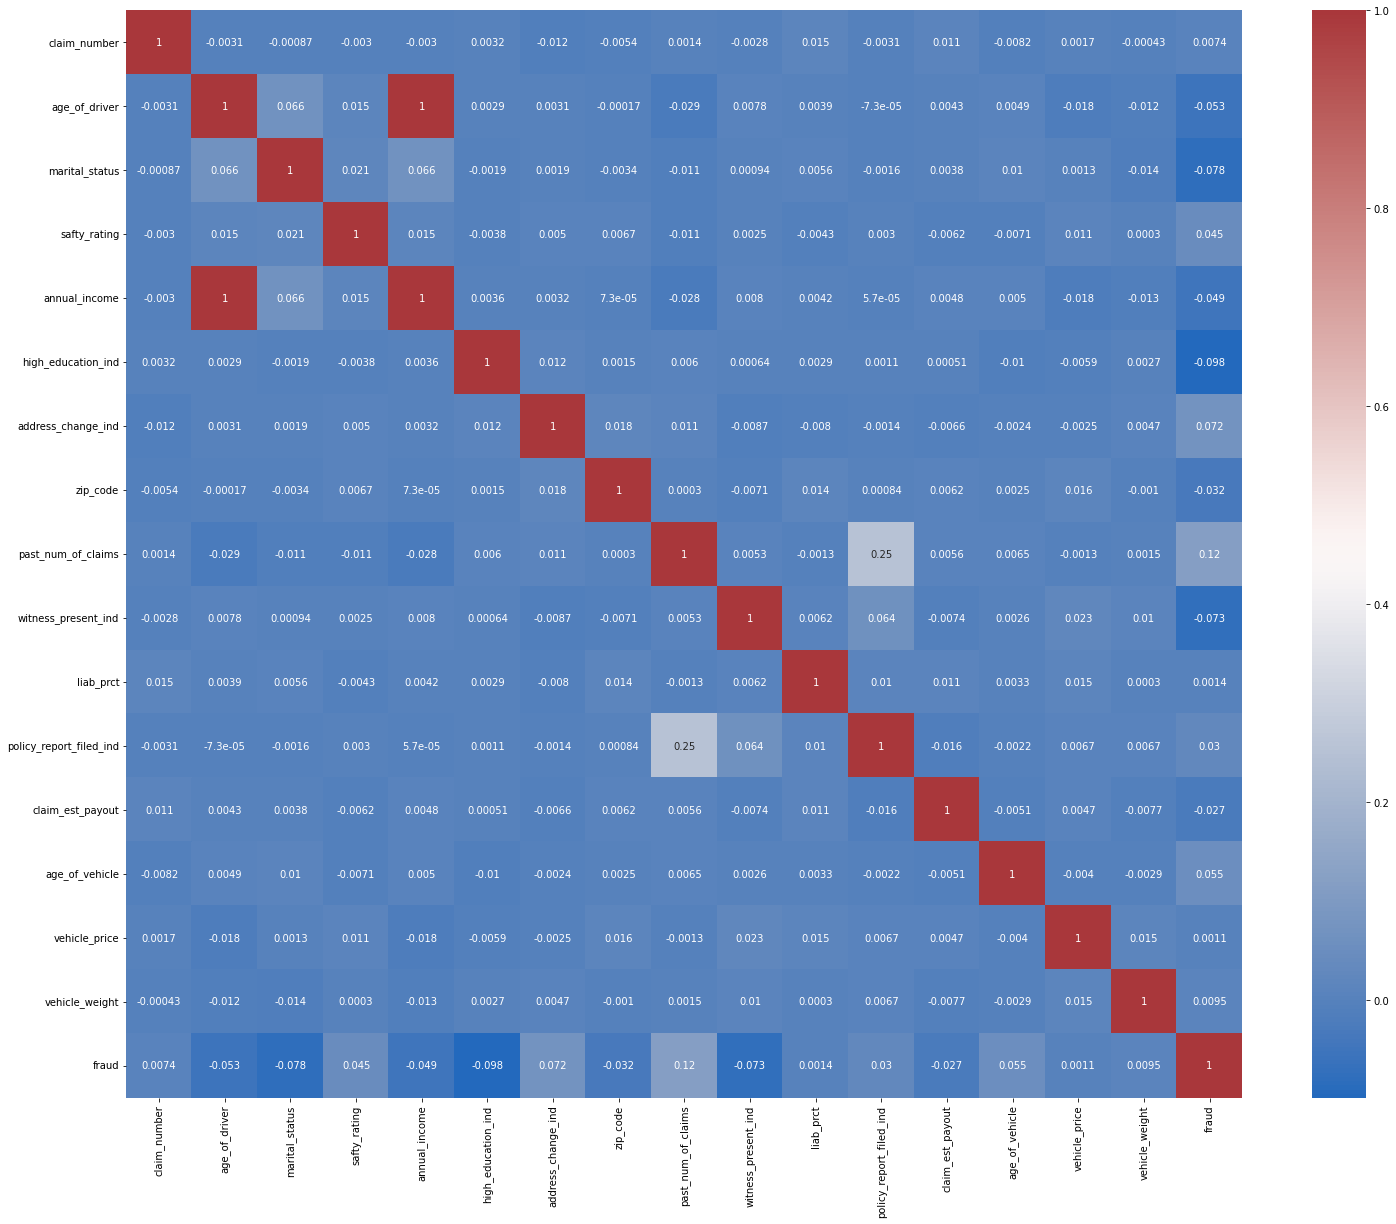

In [ ]:
corr = train_t.corr()
top_correlated_features = corr.index
plt.figure(figsize = (25,20))

sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap="vlag", annot=True)

## Additional Feature Engineering

In [ ]:
incomeage = pd.DataFrame(np.log(train.annual_income/train.age_of_driver))
train_t['income_age']=incomeage
incomeage_test = pd.DataFrame(np.log(test.annual_income/test.age_of_driver))
test_t['income_age']=incomeage_test

In [ ]:
train_t.head()

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,claim_date,claim_day_of_week,accident_site,past_num_of_claims,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud,income_age
0,1,3.828641,M,1.0,2.571282,10.553231,1,1,Rent,80006,12/16/2016,Friday,Local,1,0.0,74,Broker,0,86.780994,3.000000,Compact,9.463854,white,16161.33381,0,6.724590
1,3,3.044522,F,0.0,3.000000,10.323677,0,1,Rent,15021,2/12/2015,Thursday,Highway,1,1.0,79,Online,0,54.461224,2.000000,Large,10.289751,white,28691.96422,0,7.279155
2,4,3.891820,F,0.0,2.466212,10.569341,0,1,Own,20158,12/6/2016,Tuesday,Local,0,0.0,0,Broker,0,79.270980,1.732051,Compact,9.985122,white,22090.94758,1,6.677520
3,5,4.060443,F,1.0,3.530348,10.611646,1,0,Own,15024,5/5/2016,Thursday,Local,3,0.0,99,Broker,1,78.547743,2.000000,Medium,9.487841,other,38329.58106,1,6.551203
4,6,3.637586,M,1.0,1.912931,10.501774,1,0,Rent,50034,10/27/2015,Tuesday,Highway,0,1.0,7,Broker,0,67.389815,2.645751,Medium,10.546925,gray,25876.56319,0,6.864188


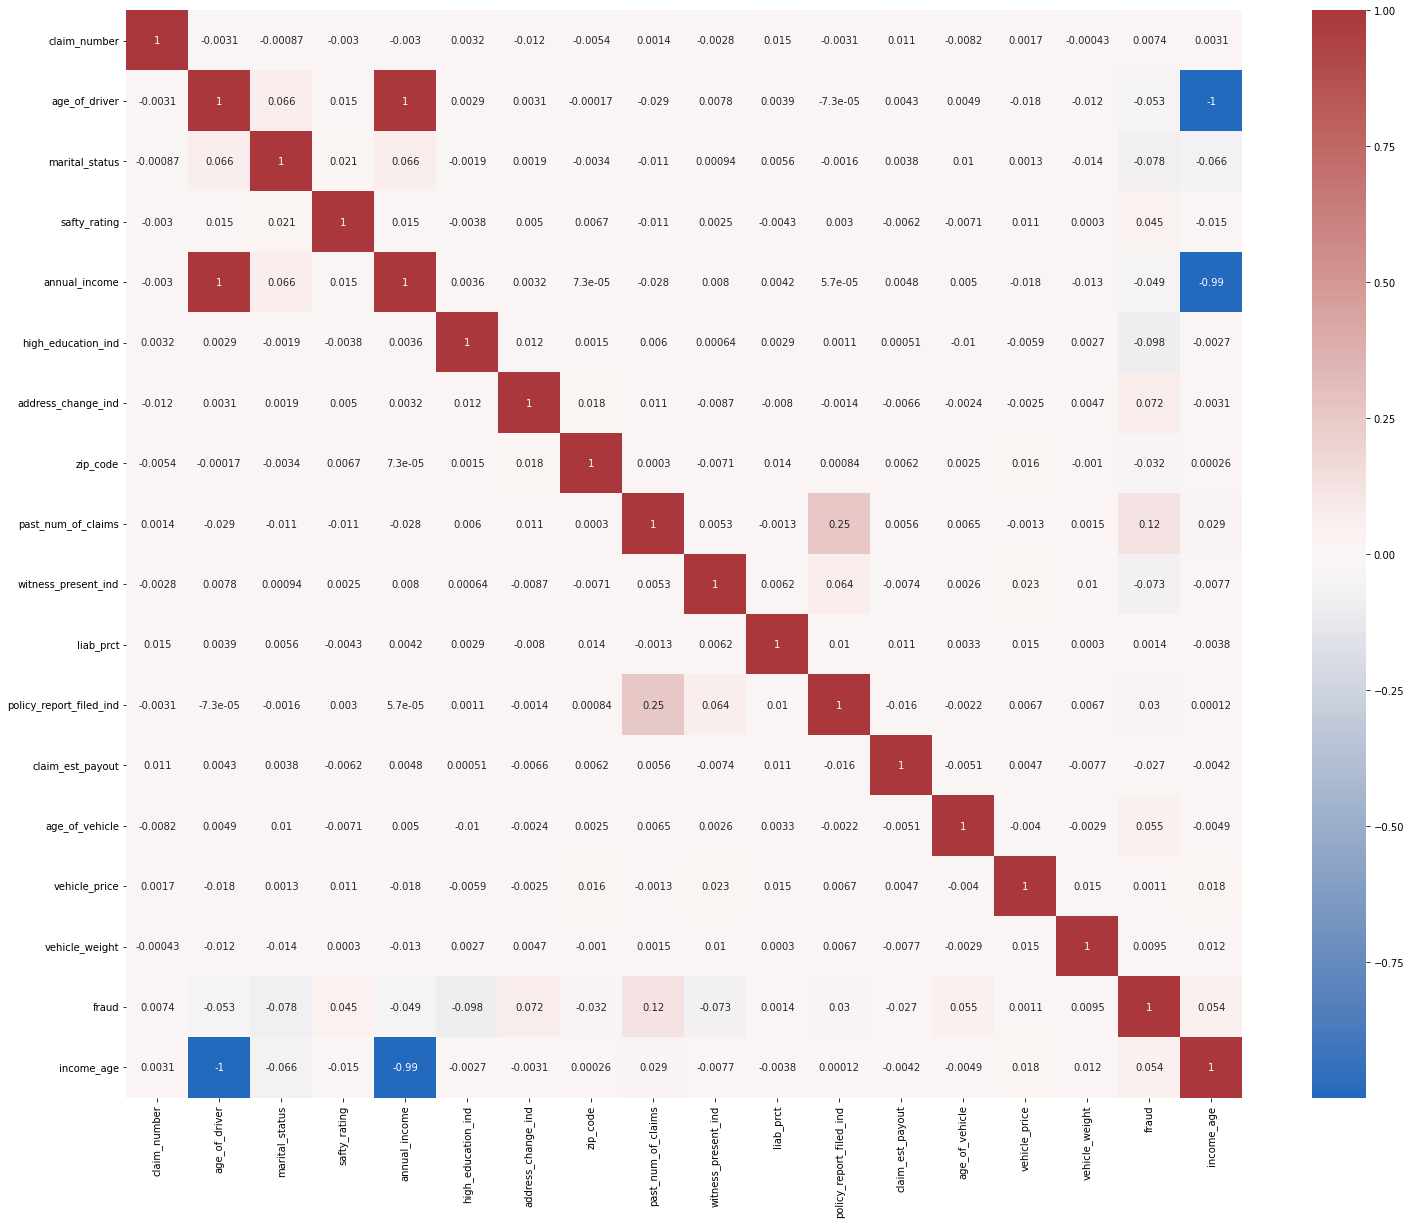

In [ ]:
corr = train_t.corr()
top_correlated_features = corr.index
plt.figure(figsize = (25,20))

sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap="vlag", annot=True)

In [ ]:
train_t.columns

Index(['claim_number', 'age_of_driver', 'gender', 'marital_status',
       'safty_rating', 'annual_income', 'high_education_ind',
       'address_change_ind', 'living_status', 'zip_code', 'claim_date',
       'claim_day_of_week', 'accident_site', 'past_num_of_claims',
       'witness_present_ind', 'liab_prct', 'channel',
       'policy_report_filed_ind', 'claim_est_payout', 'age_of_vehicle',
       'vehicle_category', 'vehicle_price', 'vehicle_color', 'vehicle_weight',
       'fraud', 'income_age'],
      dtype='object')

### Check the distribution

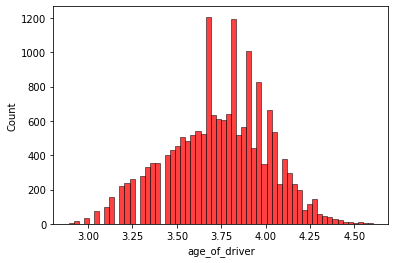

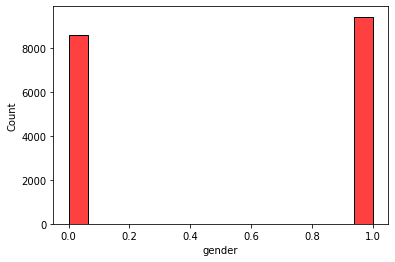

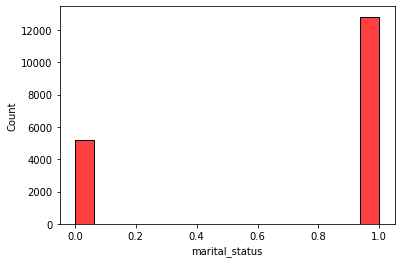

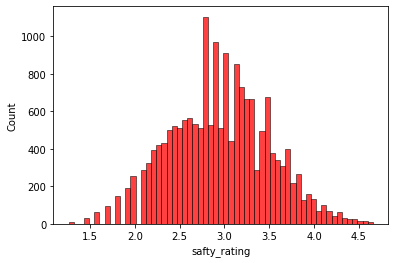

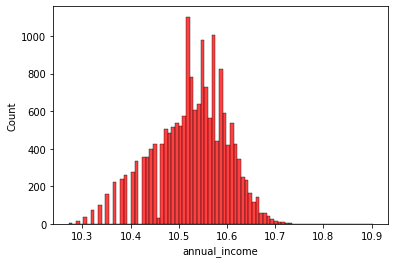

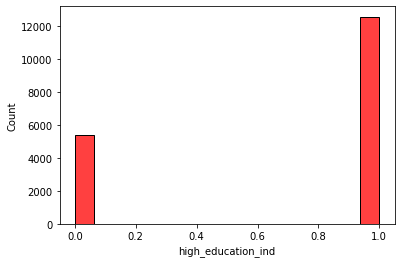

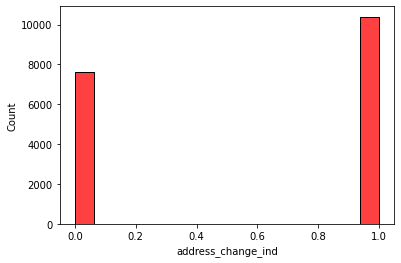

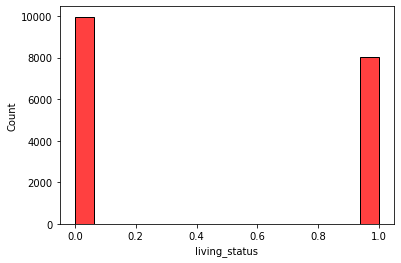

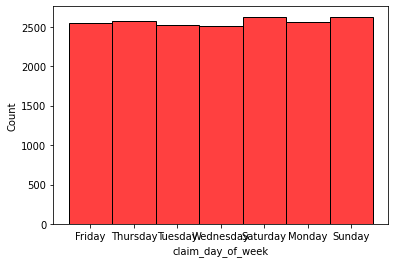

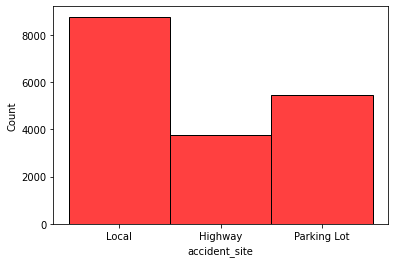

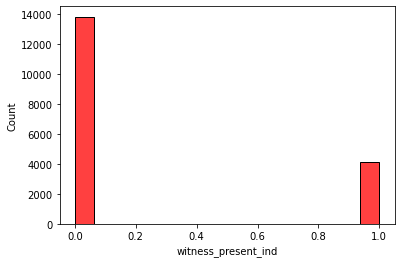

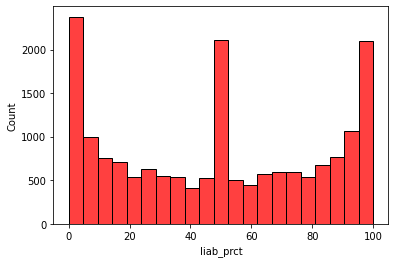

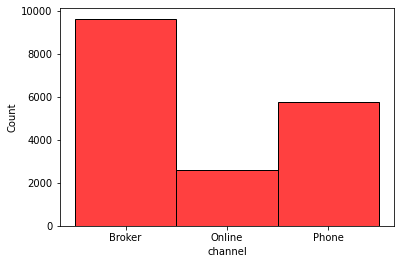

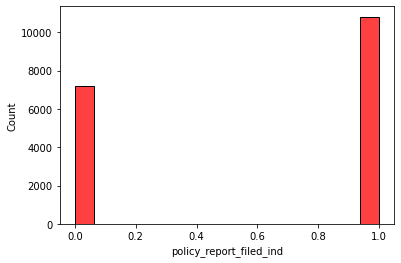

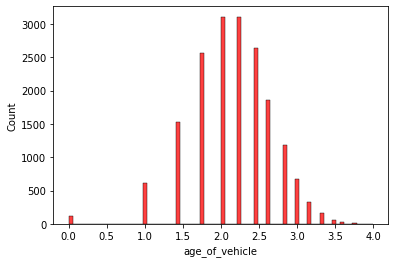

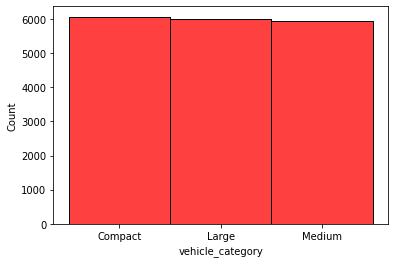

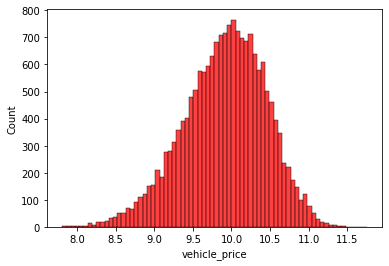

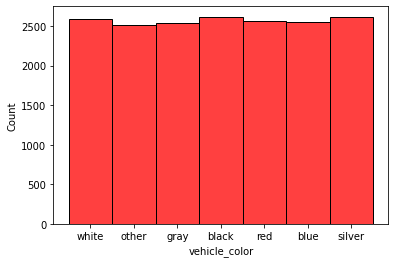

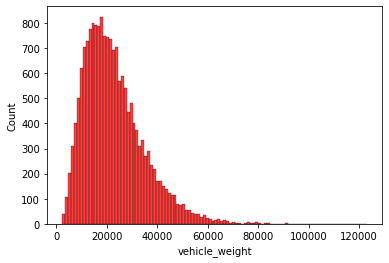

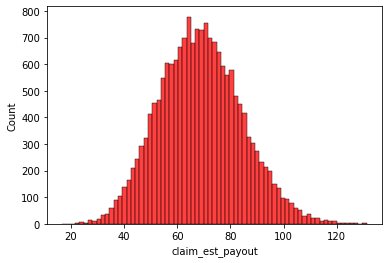

In [ ]:
sns.histplot(train_t.age_of_driver,color='red')
plt.show()
sns.histplot(train_t.gender,color='red')
plt.show()
sns.histplot(train_t.marital_status,color='red')
plt.show()
sns.histplot(train_t.safty_rating,color='red')
plt.show()
sns.histplot(train_t.annual_income,color='red')
plt.show()
sns.histplot(train_t.high_education_ind,color='red')
plt.show()
sns.histplot(train_t.address_change_ind,color='red')
plt.show()
sns.histplot(train_t.living_status,color='red')
plt.show()
sns.histplot(train_t.claim_day_of_week,color='red')
plt.show()
sns.histplot(train_t.accident_site,color='red')
plt.show()
sns.histplot(train_t.witness_present_ind,color='red')
plt.show()
sns.histplot(train_t.liab_prct,color='red')
plt.show()
sns.histplot(train_t.channel,color='red')
plt.show()
sns.histplot(train_t.policy_report_filed_ind,color='red')
plt.show()
sns.histplot(train_t.age_of_vehicle,color='red')
plt.show()
sns.histplot(train_t.vehicle_category,color='red')
plt.show()
sns.histplot(train_t.vehicle_price,color='red')
plt.show()
sns.histplot(train_t.vehicle_color,color='red')
plt.show()
sns.histplot(train_t.vehicle_weight,color='red')
plt.show()
sns.histplot(train_t.claim_est_payout,color='red')
plt.show()

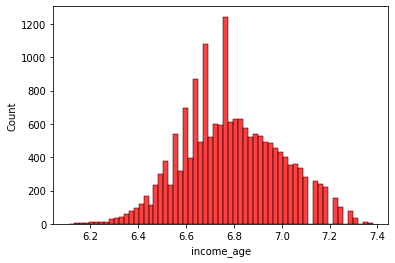

In [ ]:
sns.histplot(train_t.income_age,color='red')
plt.show()

In [ ]:
train.columns

Index(['claim_number', 'age_of_driver', 'gender', 'marital_status',
       'safty_rating', 'annual_income', 'high_education_ind',
       'address_change_ind', 'living_status', 'zip_code', 'claim_date',
       'claim_day_of_week', 'accident_site', 'past_num_of_claims',
       'witness_present_ind', 'liab_prct', 'channel',
       'policy_report_filed_ind', 'claim_est_payout', 'age_of_vehicle',
       'vehicle_category', 'vehicle_price', 'vehicle_color', 'vehicle_weight',
       'fraud'],
      dtype='object')

In [ ]:
test.columns

Index(['claim_number', 'age_of_driver', 'gender', 'marital_status',
       'safty_rating', 'annual_income', 'high_education_ind',
       'address_change_ind', 'living_status', 'zip_code', 'claim_date',
       'claim_day_of_week', 'accident_site', 'past_num_of_claims',
       'witness_present_ind', 'liab_prct', 'channel',
       'policy_report_filed_ind', 'claim_est_payout', 'age_of_vehicle',
       'vehicle_category', 'vehicle_price', 'vehicle_color', 'vehicle_weight'],
      dtype='object')

In [ ]:
train_y = train_t.fraud
train_x = train_t.copy().drop(columns=['fraud', 'claim_number',  'claim_date', 'zip_code', 'vehicle_color'])

In [ ]:
categorical_features_indices = np.where(train_x.dtypes != np.float)[0]

In [ ]:
categorical_features_indices

array([ 1,  5,  6,  7,  8,  9, 10, 12, 13, 14, 17])

In [ ]:
train_x.head()

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,claim_day_of_week,accident_site,past_num_of_claims,witness_present_ind,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_weight,income_age
0,3.828641,M,1.0,2.571282,10.553231,1,1,Rent,Friday,Local,1,0.0,74,Broker,0,86.780994,3.000000,Compact,9.463854,16161.33381,6.724590
1,3.044522,F,0.0,3.000000,10.323677,0,1,Rent,Thursday,Highway,1,1.0,79,Online,0,54.461224,2.000000,Large,10.289751,28691.96422,7.279155
2,3.891820,F,0.0,2.466212,10.569341,0,1,Own,Tuesday,Local,0,0.0,0,Broker,0,79.270980,1.732051,Compact,9.985122,22090.94758,6.677520
3,4.060443,F,1.0,3.530348,10.611646,1,0,Own,Thursday,Local,3,0.0,99,Broker,1,78.547743,2.000000,Medium,9.487841,38329.58106,6.551203
4,3.637586,M,1.0,1.912931,10.501774,1,0,Rent,Tuesday,Highway,0,1.0,7,Broker,0,67.389815,2.645751,Medium,10.546925,25876.56319,6.864188


In [ ]:
test_x = test_t.copy().drop(columns=['claim_number', 'claim_date', 'zip_code', 'vehicle_color'])

In [ ]:
print(train_x.columns)
print(test_x.columns)

Index(['age_of_driver', 'gender', 'marital_status', 'safty_rating',
       'annual_income', 'high_education_ind', 'address_change_ind',
       'living_status', 'claim_day_of_week', 'accident_site',
       'past_num_of_claims', 'witness_present_ind', 'liab_prct', 'channel',
       'policy_report_filed_ind', 'claim_est_payout', 'age_of_vehicle',
       'vehicle_category', 'vehicle_price', 'vehicle_weight', 'income_age'],
      dtype='object')
Index(['age_of_driver', 'gender', 'marital_status', 'safty_rating',
       'annual_income', 'high_education_ind', 'address_change_ind',
       'living_status', 'claim_day_of_week', 'accident_site',
       'past_num_of_claims', 'witness_present_ind', 'liab_prct', 'channel',
       'policy_report_filed_ind', 'claim_est_payout', 'age_of_vehicle',
       'vehicle_category', 'vehicle_price', 'vehicle_weight', 'income_age'],
      dtype='object')


In [ ]:
print(train_x.shape)
print(train_y.shape)

(17995, 21)
(17995,)


In [ ]:
print(test_x.shape)

(12002, 21)


# Modeling

In [ ]:
categorical_features_indices = np.where(train_x.dtypes != np.float)[0]

In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install hyperopt

     |████████████████████████████████| 76.1 MB 1.3 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
from catboost import CatBoostClassifier, Pool, metrics, cv
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric=metrics.AUC(),
        random_seed=42,
        verbose=False,
        loss_function=metrics.Logloss(),
    )

    cv_data = cv(
        Pool(train_x, train_y, cat_features=categorical_features_indices),
        model.get_params()
    )
    best_auc = np.max(cv_data['test-AUC-mean'])

    return 1 - best_auc # as hyperopt minimises

In [ ]:
from numpy.random import RandomState
from catboost import CatBoostClassifier


params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]Training on fold [0/3]


Custom logger is already specified. Specify more than one logger at same time is not thread safe.


bestTest = 0.7068604857
bestIteration = 26

Training on fold [1/3]

bestTest = 0.7200318226
bestIteration = 25

Training on fold [2/3]

bestTest = 0.7147400546
bestIteration = 26

  2%|▏         | 1/50 [00:58<47:35, 58.27s/it, best loss: 0.2862899370951304]Training on fold [0/3]

bestTest = 0.7074942016
bestIteration = 32

Training on fold [1/3]

bestTest = 0.7163353917
bestIteration = 28

Training on fold [2/3]

bestTest = 0.721023058
bestIteration = 18

  4%|▍         | 2/50 [01:52<44:49, 56.03s/it, best loss: 0.2862899370951304]Training on fold [0/3]

bestTest = 0.7023473378
bestIteration = 16

Training on fold [1/3]

bestTest = 0.7158521596
bestIteration = 20

Training on fold [2/3]

bestTest = 0.7223085291
bestIteration = 21

  6%|▌         | 3/50 [02:46<43:11, 55.15s/it, best loss: 0.2862899370951304]Training on fold [0/3]

bestTest = 0.7095565672
bestIteration = 31

Training on fold [1/3]

bestTest = 0.715891096
bestIteration = 16

Training on fold [2/3]

bestTest = 0.722680051

In [ ]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric=metrics.AUC(),
    random_seed=42,
    verbose=False,
)

In [ ]:
model.fit(train_x, train_y, cat_features=categorical_features_indices)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [ ]:
cv_data = cv(Pool(train_x, train_y, cat_features=categorical_features_indices), model.get_params())

NameError: ignored

In [ ]:
model.get_feature_importance(Pool(train_x, train_y, cat_features=categorical_features_indices))

array([ 4.78329242,  2.19420959,  4.10096097,  6.42889943,  5.91877433,
        7.12874076,  4.73953627,  0.98468412,  0.58449733, 15.73781992,
        7.82162783,  8.10327697,  3.07547396,  2.4425304 ,  0.36305728,
        8.00303104,  5.52007501,  1.29612928,  2.25546044,  1.99072126,
        6.5272014 ])

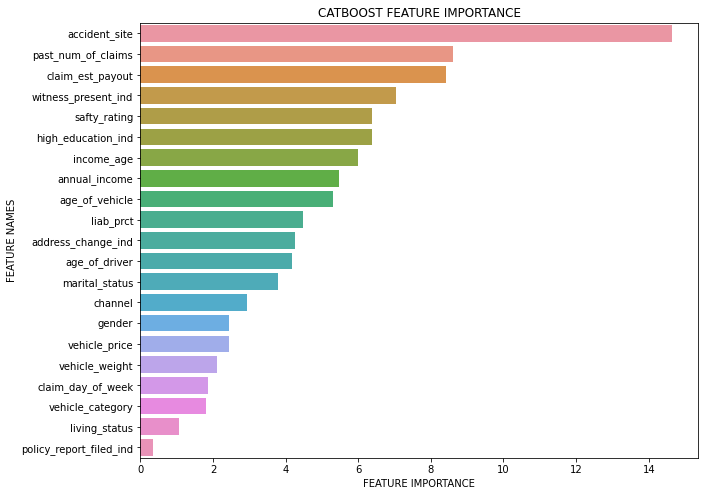

In [ ]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.get_feature_importance(),train_x.columns,'CATBOOST')

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(train_y, np.round(model.predict(train_x))))
tn, fp, fn, tp = confusion_matrix(train_y, np.round(model.predict(train_x))).ravel()
(tn, fp, fn, tp)

[[15163    16]
 [ 2686   130]]


(15163, 16, 2686, 130)

In [ ]:
submisstion = pd.DataFrame()
submisstion['claim_number'] = test_x['claim_number']
submisstion['fraud'] = model.predict(test_x)

In [ ]:
submisstion.to_csv('submission_etx.csv', index=False)